# Import dependencies

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

     

1 Physical GPUs, 1 Logical GPUs
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Load datasets and extract images

In [ ]:
dataset = np.load('../Datasets/pathmnist.npz')
print("dataset keys: ", pd.DataFrame(dataset).head())
# extract images
train_images = dataset['train_images']
val_images = dataset['val_images']
test_images = dataset['test_images']
# extract labels
train_labels = dataset['train_labels']
val_labels = dataset['val_labels']
test_labels = dataset['test_labels']

# visualise data shape
train_images_shape = np.shape(train_images)
train_labels_shape = np.shape(train_labels)
val_images_shape = np.shape(val_images)
val_labels_shape = np.shape(val_labels)
test_images_shape = np.shape(test_images)
test_labels_shape = np.shape(test_labels)

print("train_images_shape: ", train_images_shape)
print("train_labels_shape: ", train_labels_shape)
print("val_images_shape: ", val_images_shape)
print("val_labels_shape: ", val_labels_shape)
print("test_images_shape: ", test_images_shape)
print("test_labels_shape: ", test_labels_shape)
print("shape of one image", np.shape(train_images[0]))
class_mapping = {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}

dataset keys:                0
0  train_images
1    val_images
2   test_images
3  train_labels
4    val_labels
train_images_shape:  (89996, 28, 28, 3)
train_labels_shape:  (89996, 1)
val_images_shape:  (10004, 28, 28, 3)
val_labels_shape:  (10004, 1)
test_images_shape:  (7180, 28, 28, 3)
test_labels_shape:  (7180, 1)
shape of one image (28, 28, 3)


# Visualise images

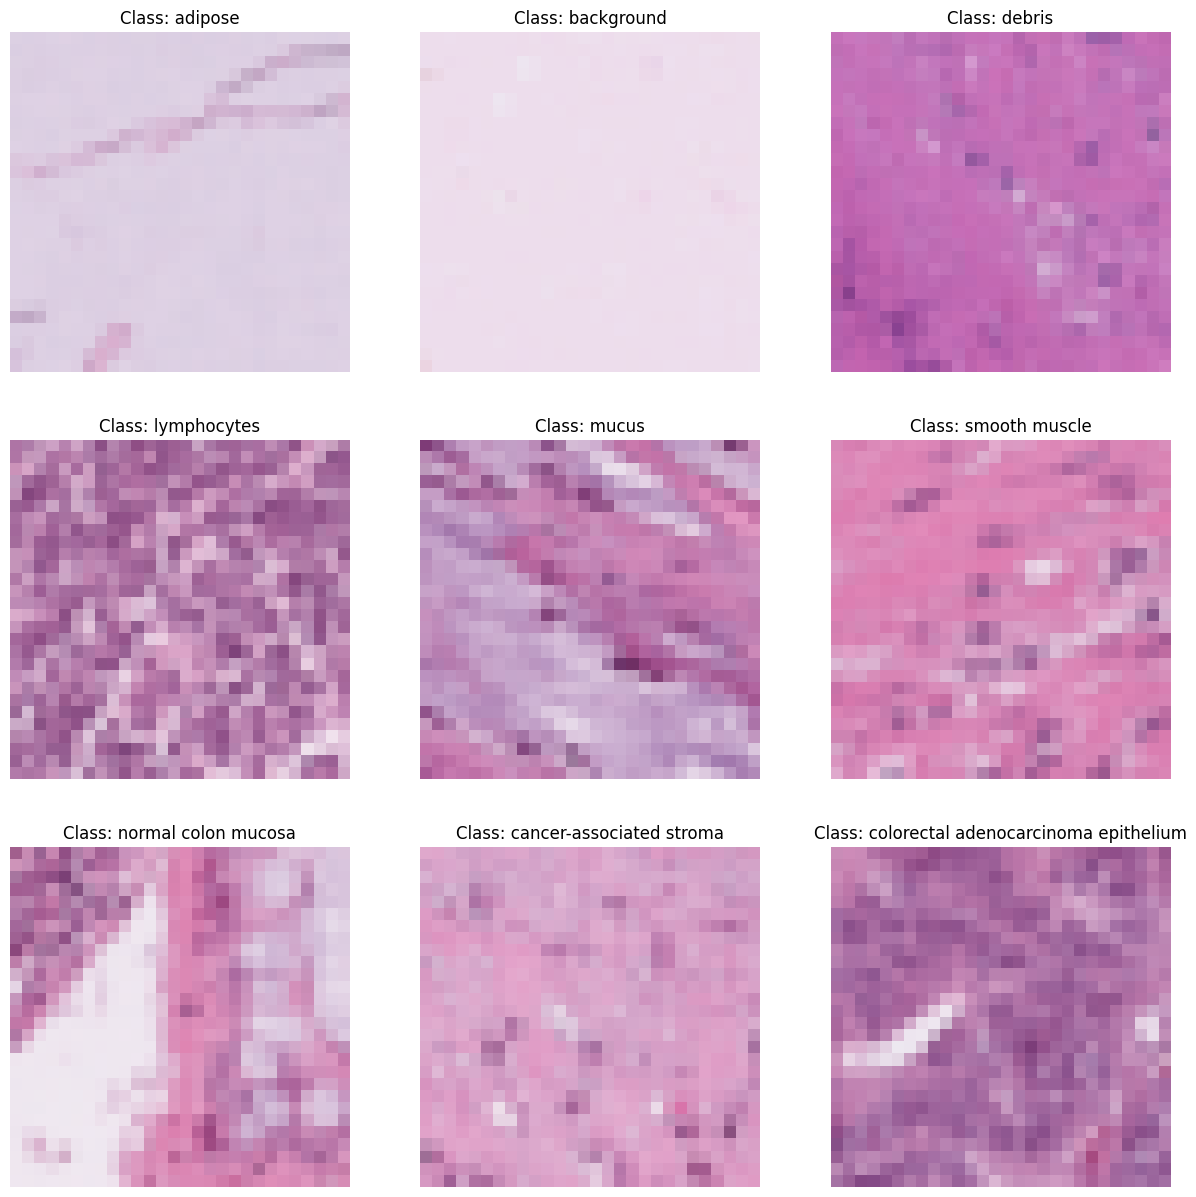

In [21]:
def visualize_one_image_per_class(images, labels, class_mapping):
    unique_classes = np.unique(labels)
    indices = []
    for cls in unique_classes:
        idx = np.where(labels == cls)[0][0]
        indices.append(idx)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(3, 3, i + 1)  
        plt.imshow(images[idx], cmap='gray')  
        plt.title("Class: " + class_mapping[str(labels[idx][0])])
        plt.axis('off')
    plt.show()

visualize_one_image_per_class(train_images, train_labels, class_mapping)



# Visualise distribution of data

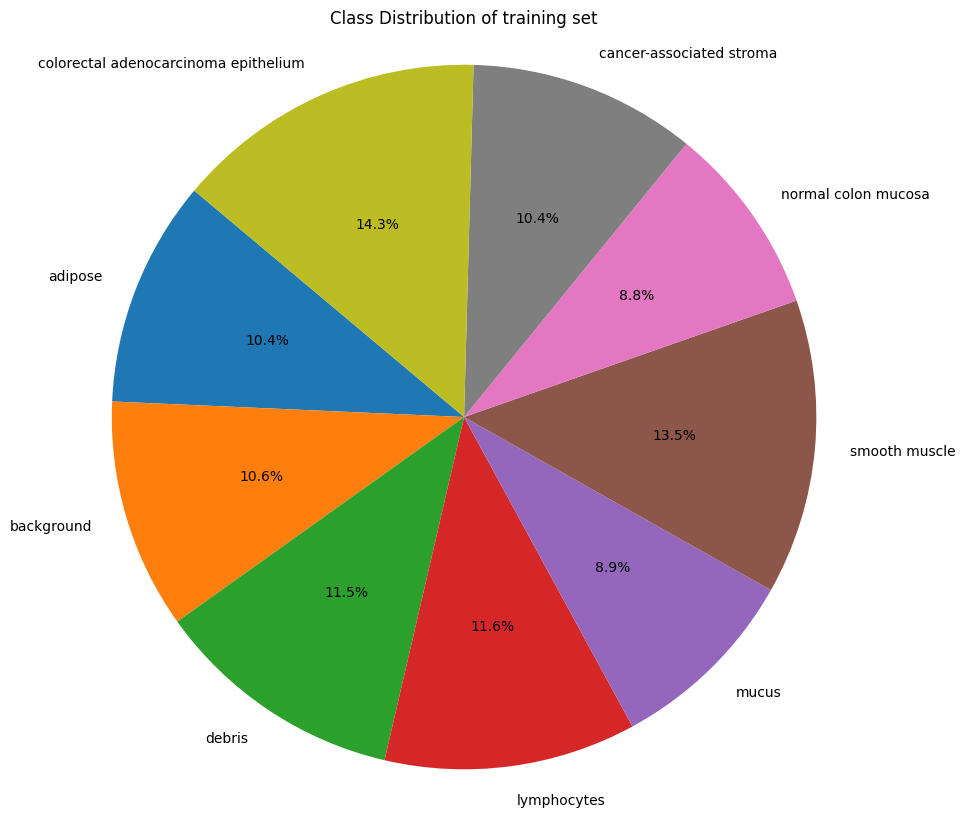

In [22]:
def plot_class_distribution(labels, class_mapping):
    class_counts = np.bincount(labels.flatten())
    pie_labels = [class_mapping[str(i)] for i in range(len(class_counts))]
    sizes = class_counts

    plt.figure(figsize=(10, 10))
    plt.pie(sizes, labels=pie_labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title('Class Distribution of training set')
    plt.show()

plot_class_distribution(train_labels, class_mapping)

# Transform data

In [23]:
# one hot encoding of labels
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_enc = to_categorical(train_labels, num_classes=len(class_mapping))
val_labels_enc = to_categorical(val_labels, num_classes=len(class_mapping))
test_labels_enc = to_categorical(test_labels, num_classes=len(class_mapping))

# Now check the new shape of the labels
print("New train_labels shape: ", train_labels_enc.shape)

# convert to floating point images
train_images_float = train_images.astype('float32') / 255
val_images_float = val_images.astype('float32') / 255
test_images_float = test_images.astype('float32') / 255


New train_labels shape:  (89996, 9)


# Create CNN model

In [39]:
# Create CNN model, starting from base model created in task A, tweaked to fit input of pathmnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

l2_reg = 0.001
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(28, 28, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

model.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, 
#     show_dtype=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

                                                                 
Total params: 122441 (478.29 KB)
Trainable params: 122441 (478.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_images_float,
    train_labels_enc, 
    epochs=30, 
    validation_data=(val_images_float, val_labels_enc),
    callbacks=[early_stopping]
)

Epoch 1/30
2813/2813 [==============================] - 29s 10ms/step - loss: 1.7971 - accuracy: 0.3427 - val_loss: 1.3770 - val_accuracy: 0.5376
Epoch 2/30
2813/2813 [==============================] - 28s 10ms/step - loss: 1.4050 - accuracy: 0.5051 - val_loss: 1.2517 - val_accuracy: 0.5619
Epoch 3/30
2813/2813 [==============================] - 28s 10ms/step - loss: 1.2813 - accuracy: 0.5575 - val_loss: 1.1102 - val_accuracy: 0.6282
Epoch 4/30
2813/2813 [==============================] - 25s 9ms/step - loss: 1.2247 - accuracy: 0.5832 - val_loss: 1.0553 - val_accuracy: 0.6546
Epoch 5/30
2813/2813 [==============================] - 24s 9ms/step - loss: 1.1816 - accuracy: 0.6007 - val_loss: 1.1180 - val_accuracy: 0.6143
Epoch 6/30
2813/2813 [==============================] - 24s 9ms/step - loss: 1.1439 - accuracy: 0.6149 - val_loss: 1.0288 - val_accuracy: 0.6565
Epoch 7/30
2813/2813 [==============================] - 25s 9ms/step - loss: 1.1178 - accuracy: 0.6287 - val_loss: 0.9624 - val

# Access performance of model

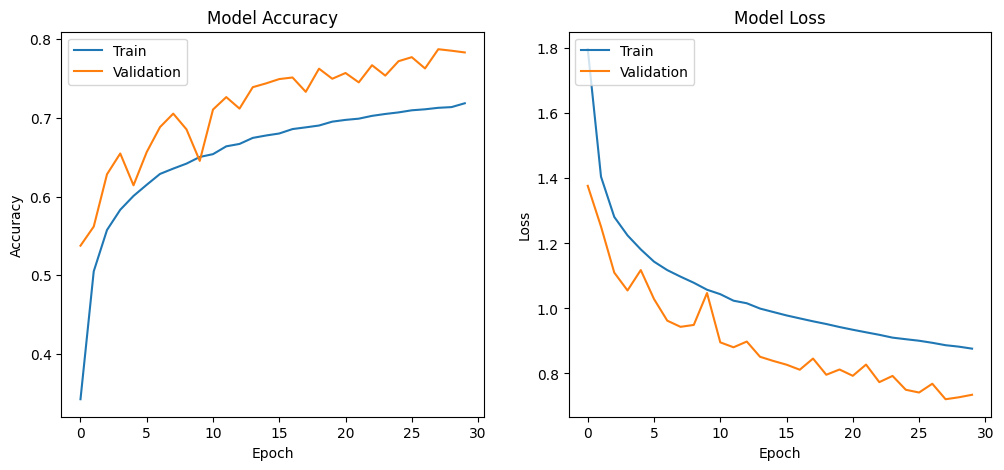

In [41]:
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

225/225 [==============================] - 1s 6ms/step - loss: 1.0353 - accuracy: 0.7717
Test Accuracy: 0.7717270255088806
225/225 [==============================] - 0s 2ms/step


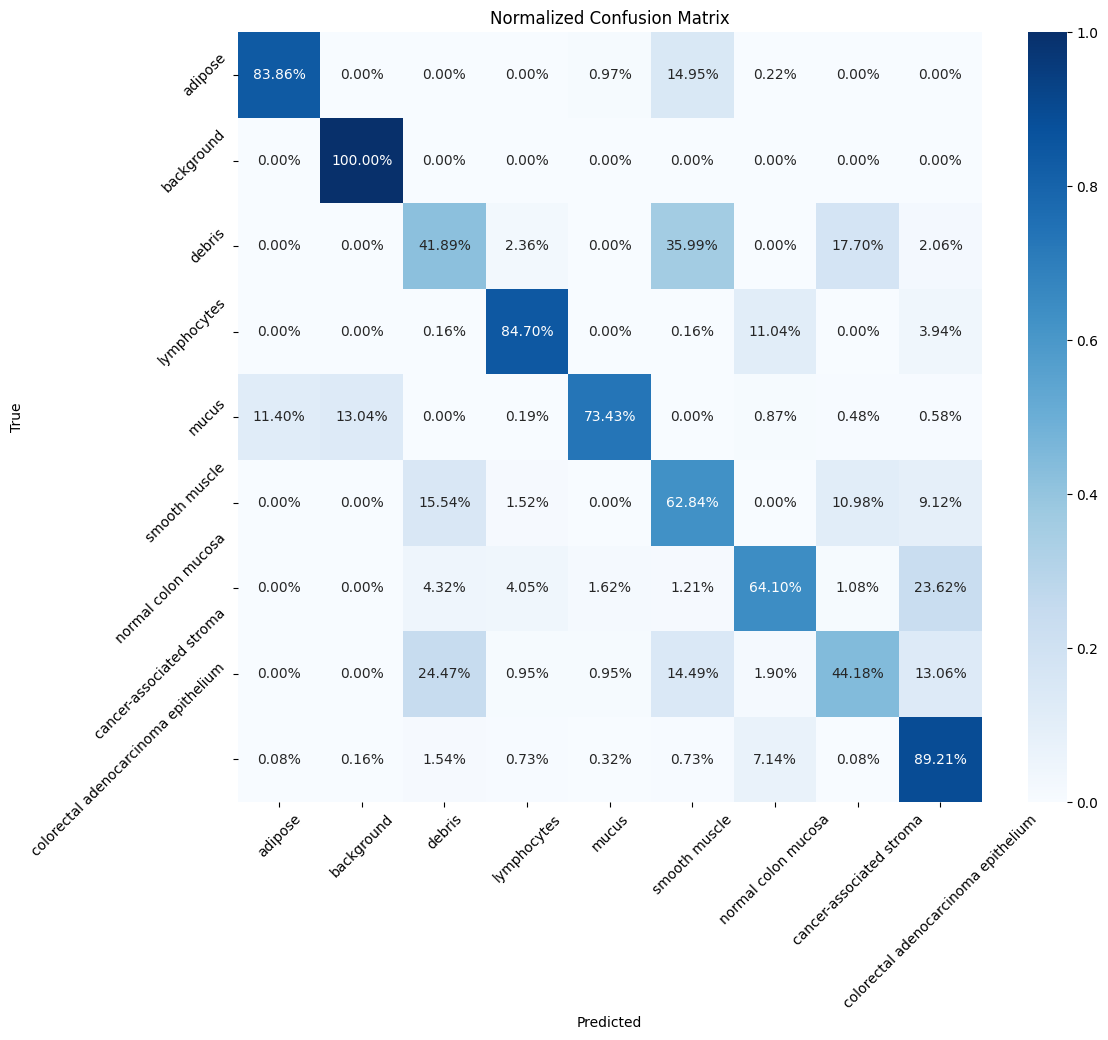

In [42]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_loss, test_acc = model.evaluate(test_images_float, test_labels_enc)
print("Test Accuracy:", test_acc)

# Predictions and true labels
predictions = model.predict(test_images_float)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_enc, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Extracting class names in the order they are mapped
class_names = [class_mapping[str(i)] for i in range(len(class_mapping))]

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [44]:
model.save("taskB_model")

INFO:tensorflow:Assets written to: taskB_model/assets


INFO:tensorflow:Assets written to: taskB_model/assets
